# Contents and why we need this lab

This lab is about implementing neural networks yourself before we start using other frameworks which hide some of the computation from you. It builds on the first lab where you derived the equations for neural network forward and backward propagation and gradient descent parameter updates. 

All the frameworks for deep learning you will meet from now on uses automatic differentiation (autodiff) so you don't have to code the backward step yourself. In this version of this lab you will develop your own autodif implementation. We also have a [version](https://github.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/blob/master/2_Feedforward_NumPy/2.1-FNN-NumPy.ipynb) of this lab where you have to code the backward pass explicitly in Numpy.

# External sources of information

1. Jupyter notebook. You can find more information about Jupyter notebooks [here](https://jupyter.org/). It will come as part of the [Anaconda](https://www.anaconda.com/) Python installation. 
2. [NumPy](https://numpy.org/). Part of Anaconda distribution. If you already know how to program most things about Python and NumPy can be found through Google search.
3. [Nanograd](https://github.com/rasmusbergpalm/nanograd) is a minimalistic version of autodiff developed by Rasmus Berg Palm that we use for our framework.


# This notebook will follow the next steps:

1. Nanograd automatic differentiation framework
2. Finite difference method
3. Data generation
4. Defining and initializing the network
5. Forward pass
6. Training loop 
7. Testing your model
8. Further extensions

# Nanograd automatic differention framework

The [Nanograd](https://github.com/rasmusbergpalm/nanograd) framework defines a class Var which both holds a value and gradient value that we can use to store the intermediate values when we apply the chain rule of differentiation.

In [1]:
# Copy and pasted from https://github.com/rasmusbergpalm/nanograd/blob/main/nanograd.py

from math import exp, log, tanh

def sigmoid(x):
    return (1/(1.0+exp(-x)))

class Var:
    """
    A variable which holds a float and enables gradient computations.
    """

    def __init__(self, val: float, grad_fn=lambda: []):
        assert type(val) == float
        self.v = val
        self.grad_fn = grad_fn
        self.grad = 0.0

    def backprop(self, bp):
        self.grad += bp
        for input, grad in self.grad_fn():
            input.backprop(grad * bp)

    def backward(self):
        self.backprop(1.0)

    def __add__(self: 'Var', other: 'Var') -> 'Var':
        return Var(self.v + other.v, lambda: [(self, 1.0), (other, 1.0)])

    def __mul__(self: 'Var', other: 'Var') -> 'Var':
        return Var(self.v * other.v, lambda: [(self, other.v), (other, self.v)])

    def __pow__(self, power):
        assert type(power) in {float, int}, "power must be float or int"
        return Var(self.v ** power, lambda: [(self, power * self.v ** (power - 1))])

    def __neg__(self: 'Var') -> 'Var':
        return Var(-1.0) * self

    def __sub__(self: 'Var', other: 'Var') -> 'Var':
        return self + (-other)

    def __truediv__(self: 'Var', other: 'Var') -> 'Var':
        return self * other ** -1

    def __repr__(self):
        return "Var(v=%.4f, grad=%.4f)" % (self.v, self.grad)

    def relu(self):
        return Var(self.v if self.v > 0.0 else 0.0, lambda: [(self, 1.0 if self.v > 0.0 else 0.0)])
    
    def identity(self): # <- remove before distribution
        return self
    
    def tanh(self):
        return Var(tanh(self.v), lambda: [(self, 1-tanh(self.v)**2)])
    
    def sigmoid(self):
        return Var(sigmoid(self.v), lambda: [( self, sigmoid(self.v)*(1-sigmoid(self.v)) )])
    
    def exp(self):
        return Var(exp(self.v), lambda: [(self, exp(self.v))])

    def log(self):
        return Var(log(self.v), lambda: [(self, self.v**(-1))])

A few examples illustrate how we can use this:

In [2]:
a = Var(3.0)
b = Var(5.0)
f = a * b

f.backward()

for v in [a, b, f]:
    print(v)

Var(v=3.0000, grad=5.0000)
Var(v=5.0000, grad=3.0000)
Var(v=15.0000, grad=1.0000)


In [3]:
a = Var(3.0)
b = Var(5.0)
c = a * b
d = Var(9.0)
e = a * d
f = c + e

f.backward()

for v in [a, b, c, d, e, f]:
    print(v)

Var(v=3.0000, grad=14.0000)
Var(v=5.0000, grad=3.0000)
Var(v=15.0000, grad=1.0000)
Var(v=9.0000, grad=3.0000)
Var(v=27.0000, grad=1.0000)
Var(v=42.0000, grad=1.0000)


## Exercise a) What is being calculated?

Explain briefly the output of the code? What is the expression we differentiate and with respect to what variables?

The code outputs the values and the grad of variables a through f.
It is evident that when f.backward() is called, all the varaibles are differentiated wrt the variables which they are part of. 


## Exercise b) How does the backward function work?

For the first example above, execute the backward function by hand to convince yourself that it indeed calculates the gradients with respect to the variables. Write down the sequence of calls to backprop for the first example above. 

```
f.backprob(1)
a.backprob(5)
b.backprob(3)
```





## Exercise c) What happens if we run backward again?

Try to execute the code below. Explain what happens.

The same algorithm is run now with 2 instead of 1 as grad for the starting object (i.e. object that do not form any other object). This will double all gradient. 

In [4]:
f.backward()

for v in [a, b, c, d, e, f]:
    print(v)

Var(v=3.0000, grad=28.0000)
Var(v=5.0000, grad=6.0000)
Var(v=15.0000, grad=2.0000)
Var(v=9.0000, grad=6.0000)
Var(v=27.0000, grad=2.0000)
Var(v=42.0000, grad=2.0000)


## Exercise d) Zero gradient

We can zero the gradient by backpropagating a -1.0 as is shown in the example below. (If you have run backward multiple time then you also have to run the cell below an equal amount of times.) Explain what is going.

When f.backward() f.backprop(1) is called. Here we call f.backprop with -1 as input, i.e. backpropagation is done using the previous gradient of f - 1. 

In [5]:
a = Var(2.0)

for v in [a, b, c, d, e, f]:
    print(v)

f.backprop(-1.0)

for v in [a, b, c, d, e, f]:
    print(v)

Var(v=2.0000, grad=0.0000)
Var(v=5.0000, grad=6.0000)
Var(v=15.0000, grad=2.0000)
Var(v=9.0000, grad=6.0000)
Var(v=27.0000, grad=2.0000)
Var(v=42.0000, grad=2.0000)
Var(v=2.0000, grad=0.0000)
Var(v=5.0000, grad=3.0000)
Var(v=15.0000, grad=1.0000)
Var(v=9.0000, grad=3.0000)
Var(v=27.0000, grad=1.0000)
Var(v=42.0000, grad=1.0000)


## Exercise e) Test correctness of derivatives with the finite difference method

Write a small function that uses [the finite difference method](https://en.wikipedia.org/wiki/Finite_difference_method) to numerically test that backpropation implementation is working. In short we will use
$$
\frac{\partial f(a)}{\partial a} \approx \frac{f(a+da)-f(a)}{da}
$$
for $da \ll 1$.


_Insert your code in the cell below._


In [6]:
# test function - try to change into other functions as well
def test_function(a):
    a = Var(a)
    b = Var(5.0)
    f = a * b
    f.backward()
    return a,b,f

for v in test_function(3.0):
    print(v)

# Insert your finite difference code here
def finite_difference(da=1e-10):
    """
    This function compute the finite difference between
    
    Input:
    da:          The finite difference                           (float)
    
    Output:
    finite_difference: numerical approximation to the derivative (float) 
    """
    
    _,_,fa_da =  test_function(3.0+da)       # <- Insert correct expression
    _,_,fa = test_function(3.0)          # <- Insert correct expression

    finite_difference = (fa_da.v - fa.v) / da
    
    return finite_difference

print(finite_difference())

Var(v=3.0000, grad=5.0000)
Var(v=5.0000, grad=3.0000)
Var(v=15.0000, grad=1.0000)
5.000000413701855


# Create an artificial dataset to play with

We create a non-linear 1d regression task. The generator supports various noise levels and it creates train, validation and test sets. You can modify it yourself if you want more or less challenging tasks.

In [7]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

In [8]:
def data_generator(noise=0.1, n_samples=300, D1=True):
    # Create covariates and response variable
    if D1:
        X = np.linspace(-3, 3, num=n_samples).reshape(-1,1) # 1-D
        np.random.shuffle(X)
        y = np.random.normal((0.5*np.sin(X[:,0]*3) + X[:,0]), noise) # 1-D with trend
    else:
        X = np.random.multivariate_normal(np.zeros(3), noise*np.eye(3), size = n_samples) # 3-D
        np.random.shuffle(X)    
        y = np.sin(X[:,0]) - 5*(X[:,1]**2) + 0.5*X[:,2] # 3-D

    # Stack them together vertically to split data set
    data_set = np.vstack((X.T,y)).T
    
    train, validation, test = np.split(data_set, [int(0.35*n_samples), int(0.7*n_samples)], axis=0)
    
    # Standardization of the data, remember we do the standardization with the training set mean and standard deviation
    train_mu = np.mean(train, axis=0)
    train_sigma = np.std(train, axis=0)
    
    train = (train-train_mu)/train_sigma
    validation = (validation-train_mu)/train_sigma
    test = (test-train_mu)/train_sigma
    
    x_train, x_validation, x_test = train[:,:-1], validation[:,:-1], test[:,:-1]
    y_train, y_validation, y_test = train[:,-1], validation[:,-1], test[:,-1]

    return x_train, y_train,  x_validation, y_validation, x_test, y_test

In [9]:
D1 = True
x_train, y_train,  x_validation, y_validation, x_test, y_test = data_generator(noise=0.5, D1=D1)

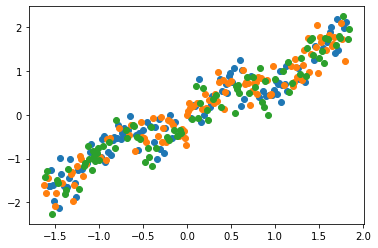

In [10]:
if D1:
    plt.scatter(x_train[:,0], y_train);
    plt.scatter(x_validation[:,0], y_validation);
    plt.scatter(x_test[:,0], y_test);
else:
    plt.scatter(x_train[:,1], y_train);
    plt.scatter(x_validation[:,1], y_validation);
    plt.scatter(x_test[:,1], y_test);
plt.show()

In [11]:
# convert from nparray to Var
def nparray_to_Var(x):
    if x.ndim==1:
        y = [[Var(float(x[i]))] for i in range(x.shape[0])] # always work with list of list
    else:
        y = [[Var(float(x[i,j])) for j in range(x.shape[1])] for i in range(x.shape[0])]
    return y
   
x_train = nparray_to_Var(x_train)
y_train = nparray_to_Var(y_train)
x_validation = nparray_to_Var(x_validation)
y_validation = nparray_to_Var(y_validation)
x_test = nparray_to_Var(x_test)
y_test = nparray_to_Var(y_test)


# Defining and initializing the network

The steps to create a feed forward neural network are the following:

1. **Number of hidden layer and hidden units**. We have to define the number of hidden units in each layer. The number of features in X and the output dimensionality (the size of Y) are given but the numbers in between are set by the researcher. Remember that for each unit in each layer beside in the input has a bias term.
2. **Activation functions** for each hidden layer. Each hidden layer in your list must have an activation function (it can also be the linear activation which is equivalent to identity function). The power of neural networks comes from non-linear activation functions that learn representations (features) from the data allowing us to learn from it. 
3. **Parameter initialization**. We will initialize the weights to have random values. This is done in practice by drawing pseudo random numbers from a Gaussian or uniform distribution. It turns out that for deeper models we have to be careful about how we scale the random numbers. This will be the topic of the exercise below. For now we will just use unit variance Gaussians.  

In order to make life easier for ourselves we define a DenseLayer class that takes care of initialization and the forward pass. We can also extend it later with print and advanced initialization capabilities. For the latter we have introduced a Initializer class.

Note that we use Sequence in the code below. A Sequence is an ordered list. This means the order we insert and access items are the same.

In [12]:
class Initializer:

    def init_weights(self, n_in, n_out):
        raise NotImplementedError

    def init_bias(self, n_out):
        raise NotImplementedError

In [13]:
import random

class NormalInitializer(Initializer):

    def __init__(self, mean=0, std=0.1):
        self.mean = mean
        self.std = std

    def init_weights(self, n_in, n_out):
        return [[Var(random.gauss(self.mean, self.std)) for _ in range(n_out)] for _ in range(n_in)]

    def init_bias(self, n_out):
        return [Var(0.0) for _ in range(n_out)]

class ConstantInitializer(Initializer):

    def __init__(self, weight=1.0, bias=0.0):
        self.weight = weight
        self.bias = bias

    def init_weights(self, n_in, n_out):
        return [[Var(self.weight) for _ in range(n_out)] for _ in range(n_in)]

    def init_bias(self, n_out):
        return [Var(self.bias) for _ in range(n_out)]

In [14]:
from typing import Sequence

class DenseLayer:
    def __init__(self, n_in: int, n_out: int, act_fn, initializer = NormalInitializer()):
        self.weights = initializer.init_weights(n_in, n_out)
        self.bias = initializer.init_bias(n_out)
        self.act_fn = act_fn
    
    def __repr__(self):    
        return 'Weights: ' + repr(self.weights) + ' Biases: ' + repr(self.bias)

    def parameters(self) -> Sequence[Var]:
        params = []
        for r in self.weights:
            params += r

        return params + self.bias

    def forward(self, inputs: Sequence[Var]) -> Sequence[Var]:
        assert len(self.weights) == len(inputs), "weights and inputs must match in first dimension"
        weights = self.weights
        out = []
        for j in range(len(weights[0])):
            node = self.bias[j]  # <- Insert code
            for i in range(len(inputs)):
                node += weights[i][j] * inputs[i]  # <- Insert code
            node = self.act_fn(node)
            out.append(node)

        return out

## Exercise f) Complete the forward pass

In the code below we initialize a 1-5-1 network and pass the training set through it. The forward method in DenseLayer is not complete. It  just outputs zeros right now. The method forward should perform an [affine transformation](https://en.wikipedia.org/wiki/Affine_transformation) on the input followed by an application of the activation function.

In [15]:
NN = [
    DenseLayer(1, 5, lambda x: x.relu()),
    DenseLayer(5, 1, lambda x: x.identity())
]

def forward(input, network):

    def forward_single(x, network):
        for layer in network:
            x = layer.forward(x)
        return x

    output = [ forward_single(input[n], network) for n in range(len(input))]
    return output
    
print(forward(x_train, NN))


[[Var(v=0.0107, grad=0.0000)], [Var(v=0.0215, grad=0.0000)], [Var(v=0.0020, grad=0.0000)], [Var(v=-0.0123, grad=0.0000)], [Var(v=0.0159, grad=0.0000)], [Var(v=0.0147, grad=0.0000)], [Var(v=0.0095, grad=0.0000)], [Var(v=-0.0030, grad=0.0000)], [Var(v=-0.0127, grad=0.0000)], [Var(v=0.0059, grad=0.0000)], [Var(v=0.0165, grad=0.0000)], [Var(v=-0.0078, grad=0.0000)], [Var(v=0.0133, grad=0.0000)], [Var(v=-0.0089, grad=0.0000)], [Var(v=0.0071, grad=0.0000)], [Var(v=0.0138, grad=0.0000)], [Var(v=0.0255, grad=0.0000)], [Var(v=0.0121, grad=0.0000)], [Var(v=0.0013, grad=0.0000)], [Var(v=0.0042, grad=0.0000)], [Var(v=-0.0058, grad=0.0000)], [Var(v=-0.0026, grad=0.0000)], [Var(v=0.0186, grad=0.0000)], [Var(v=0.0188, grad=0.0000)], [Var(v=-0.0034, grad=0.0000)], [Var(v=-0.0092, grad=0.0000)], [Var(v=0.0241, grad=0.0000)], [Var(v=0.0265, grad=0.0000)], [Var(v=0.0028, grad=0.0000)], [Var(v=0.0167, grad=0.0000)], [Var(v=-0.0115, grad=0.0000)], [Var(v=0.0040, grad=0.0000)], [Var(v=-0.0101, grad=0.0000)]

## Exercise g) Print all network parameters

Make a function that prints all the parameters of the network (weights and biases) with information about in which layer the appear. In the object oriented spirit you should introduce a method in the DenseLayer class to print the parameters of a layer. Hint: You can take inspiration from the corresponding method in Var. 

In [16]:
# Insert code here and in the DenseLayer class
ii = 1
for layer in NN:    
    print("Layer ", str(ii), "\n")
    print(NN)
    print("\n")
    ii+=1

Layer  1 

[Weights: [[Var(v=0.1268, grad=0.0000), Var(v=0.0530, grad=0.0000), Var(v=0.0431, grad=0.0000), Var(v=-0.1032, grad=0.0000), Var(v=0.0490, grad=0.0000)]] Biases: [Var(v=0.0000, grad=0.0000), Var(v=0.0000, grad=0.0000), Var(v=0.0000, grad=0.0000), Var(v=0.0000, grad=0.0000), Var(v=0.0000, grad=0.0000)], Weights: [[Var(v=0.0734, grad=0.0000)], [Var(v=-0.0888, grad=0.0000)], [Var(v=0.0580, grad=0.0000)], [Var(v=-0.0783, grad=0.0000)], [Var(v=0.1580, grad=0.0000)]] Biases: [Var(v=0.0000, grad=0.0000)]]


Layer  2 

[Weights: [[Var(v=0.1268, grad=0.0000), Var(v=0.0530, grad=0.0000), Var(v=0.0431, grad=0.0000), Var(v=-0.1032, grad=0.0000), Var(v=0.0490, grad=0.0000)]] Biases: [Var(v=0.0000, grad=0.0000), Var(v=0.0000, grad=0.0000), Var(v=0.0000, grad=0.0000), Var(v=0.0000, grad=0.0000), Var(v=0.0000, grad=0.0000)], Weights: [[Var(v=0.0734, grad=0.0000)], [Var(v=-0.0888, grad=0.0000)], [Var(v=0.0580, grad=0.0000)], [Var(v=-0.0783, grad=0.0000)], [Var(v=0.1580, grad=0.0000)]] Biases

# Activation functions

To have a full definition of the neural network, we must define an activation function for every layer. Several activation functions have been proposed and have different characteristics. In the Var class we have already defined the rectified linear init (relu). 
 

## Exercise h) Add more activation functions

Implement the following activation functions in the Var class:

* Identity: $$\mathrm{identity}(x) = x$$
* Hyperbolic tangent: $$\tanh(x)$$
* Sigmoid (or logistic function): $$\mathrm{sigmoid}(x) = \frac{1}{1.0 + \exp(-x ) }$$  Hint: $\mathrm{sigmoid}'(x)= \mathrm{sigmoid}(x)(1-\mathrm{sigmoid}(x))$.  

Hint: You can seek inspiration in the relu method in the Var class.

## Visualization

Now that we have defined our activation functions we can visualize them to see what they look like:

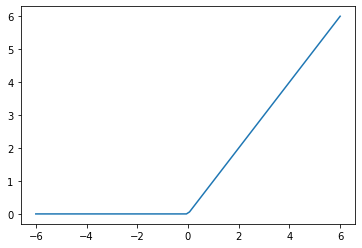

In [17]:
x = np.linspace(-6, 6, 100)

# convert from Var to ndarray  
def Var_to_nparray(x):
    y = np.zeros((len(x),len(x[0])))
    for i in range(len(x)):
        for j in range(len(x[0])):
            y[i,j] = x[i][j].v
    return y

# define 1-1 network with weight = 1 and relu activation 
NN = [ DenseLayer(1, 1, lambda x: x.relu(), initializer = ConstantInitializer(1.0)) ] 
y = Var_to_nparray(forward(nparray_to_Var(x), NN))

#y = Var_to_nparray(relu(nparray_to_Var(x)))
plt.plot(x,y)

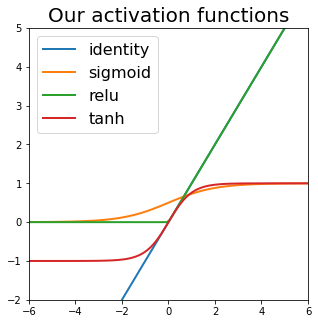

In [18]:
# Testing all activation layers

x = np.linspace(-6, 6, 100)
units = {
    "identity": lambda x: x.identity(),
    "sigmoid": lambda x: x.sigmoid(),  #<- uncomment before sharing
    "relu": lambda x: x.relu(),
    "tanh": lambda x: x.tanh() #<- uncomment before sharing
}

plt.figure(figsize=(5, 5))
[plt.plot(x, Var_to_nparray(forward(nparray_to_Var(x), [DenseLayer(1, 1, unit, initializer = ConstantInitializer(1.0))]) ), label=unit_name, lw=2) for unit_name, unit in units.items()] # unit(nparray_to_Var(x))), label=unit_name, lw=2) for unit_name, unit in units.items()]
plt.legend(loc=2, fontsize=16)
plt.title('Our activation functions', fontsize=20)
plt.ylim([-2, 5])
plt.xlim([-6, 6])
plt.show()

# Advanced initialization schemes

If we are not careful with initialization, the signals we propagate forward ($a^{(l)}$, $l=1,\ldots,L$) and backward ($\delta^l$, $l=L,L-1,\ldots,1$) can blow up or shrink to zero. A statistical analysis of the variance of the signals for different activation functions can be found in these two papers: [Glorot initialization](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) and [He initialization](https://arxiv.org/pdf/1502.01852v1.pdf). 

The result of the analyses are proposals for how to make the initialization such that the variance of the signals (forward and backward) are kept approxmimatly constant when propagating from layer to layer. The exact expressions depend upon the non-linear activation function used. In Glorot initialization, the aim is to keep both the forward and backward variances constant whereas He only aims at keeping the variance in the forward pass constant.

We define $n_{in}$ and $n_{out}$ as the number of input units and output units of a particular layer. 

The Glorot initialization has the form: 

$$w_{ij} \sim N \bigg( 0, \, \frac{2 \alpha }{n_{in} + n_{out}} \bigg) \ . $$

where $N(\mu,\sigma^2)$ is a Gaussian distribution with mean $\mu$ and variance $\sigma^2$ and $\alpha$ is a parameter that depends upon the activation function used. For $\tanh$, $\alpha=1$ and for Rectified Linear Unit (ReLU) activations, $\alpha=2$. (It is also possible to use a uniform distribution for initialization, see [this blog post](https://mmuratarat.github.io/2019-02-25/xavier-glorot-he-weight-init).) 

The He initialization is very similar

$$w_{ij} \sim N \bigg( 0, \, \frac{\alpha}{n_{in}} \bigg) \ . $$

## Exercise i) Glorot and He initialization
 
Using the Initializer class, implement functions that implement Glorot and He 

Explain briefly how you would test numerically that these initializations have the sought after property. Hint: See plots in Glorot paper.

Comment: If you want to be more advanced then try to make a universal initializer taking both the activation function and type (Glorot or He) as argument.

In [19]:
## Glorot
def DenseLayer_Glorot_tanh(n_in: int, n_out: int):
    std = 2*1/(n_in+n_out) # <- replace with proper initialization
    return DenseLayer(n_in, n_out, lambda x: x.tanh(), initializer = NormalInitializer(std))

## He
def DenseLayer_He_relu(n_in: int, n_out: int):
    std = 2/(n_in) # <- replace with proper initialization
    return DenseLayer(n_in, n_out, lambda x: x.tanh(), initializer = NormalInitializer(std))

## Exercise j) Forward pass unit test

Write a bit of code to make a unit test that the forward pass works. This can be done by defining a simple network with for example all weights equal to one (using the ConstantInitializer method) and identity activation functions. 

Hints: Use the [assert](https://www.w3schools.com/python/ref_keyword_assert.asp), the nparray_to_Var and the Var_to_nparray commands. 

In [20]:
# Insert code here
NN = [
    DenseLayer(1, 3, lambda x: x.identity())
]

pre = NN[0].weights
forward(x_train, NN)
post = NN[0].weights

assert (pre == post)

# Loss functions

We are only missing a loss function to we need to define a loss function and its derivative with respect to the output of the neural network $y$

In [21]:
def squared_loss(t, y):
  
    # add check that sizes agree
  
    def squared_loss_single(t, y):
        Loss = Var(0.0)
        for i in range(len(t)): # sum over outputs
            Loss += (t[i]-y[i]) ** 2
        return Loss

    Loss = Var(0.0)
    for n in range(len(t)): # sum over training data
        Loss += squared_loss_single(t[n],y[n])
    return Loss

## Exercise j) Implement cross entropy loss

Insert code below to implement cross-entropy loss for general dimensionality of $t$. Use a logits formulation:
$$
\rm{Loss} = - \sum_i t_i \, log \, p_i 
$$
with $p$ given by the the softmax function in terms of the logits $h$:
$$
p_i = \frac{\exp(h_i)}{\sum_{i'} \exp(h_{i'} } .
$$
Inserting $p$ in the expression for the loss gives
$$
\rm{Loss} = - \sum_i t_i h_i + \rm{LogSumExp}(h) \ ,
$$
where 
$$
\rm{LogSumExp}(h) = \log \sum_i \exp h_i \ .
$$
This is true for $t$ being a one-hot vector. In practice you want to implement a [numerically stable](https://leimao.github.io/blog/LogSumExp/) version of LogSumExp. But we will not bother about that here.

Help: You can add these methods in the Var class:

    def exp(self):
        return Var(exp(self.v), lambda: [(self, exp(self.v))])
    
    def log(self):
        return Var(log(self.v), lambda: [(self, self.v ** -1)])

In [22]:
def cross_entropy_loss(t, h):
    
    def LogSumExp(hh):
        aux = Var(0.0)
        for l in hh: 
            for e in l:
                aux += e.exp()
        return aux.log()
     
    def loss_2(t, h):
        Loss = Var(0.0)
        for i in range(len(t)): # sum over outputs
          Loss += (t[i]*h[i])
        return Loss
    
    Loss = Var(0.0)
    for n in range(len(t)): # sum over training data
        Loss = Loss + loss_2(t[n],h[n])
    
    Loss = -Loss+LogSumExp(h)
    
    return Loss

# Backward pass

Now the magic happens! We get the calculation of the gradients for free. Just do:

In [23]:
NN = [
    DenseLayer(1, 5, lambda x: x.relu()),
    DenseLayer(5, 1, lambda x: x.identity())
]

output = forward(x_train, NN)

#Loss = squared_loss(y_train,output)
Loss = cross_entropy_loss(y_train,output)

Loss.backward()

and the gradients will be calculated:

In [24]:
[print('Layer', i, '\n', NN[i]) for i in range(len(NN))] 

Layer 0 
 Weights: [[Var(v=-0.0400, grad=-0.1339), Var(v=-0.0344, grad=1.8976), Var(v=-0.1955, grad=-10.9886), Var(v=-0.1387, grad=-0.2854), Var(v=-0.0477, grad=-1.6646)]] Biases: [Var(v=0.0000, grad=0.1220), Var(v=0.0000, grad=-1.7288), Var(v=0.0000, grad=10.0112), Var(v=0.0000, grad=0.2600), Var(v=0.0000, grad=1.5166)]
Layer 1 
 Weights: [[Var(v=0.0028, grad=1.9391)], [Var(v=-0.0392, grad=1.6661)], [Var(v=0.2268, grad=9.4717)], [Var(v=0.0059, grad=6.7209)], [Var(v=0.0344, grad=2.3115)]] Biases: [Var(v=0.0000, grad=1.0000)]


[None, None]

# Backward pass unit test

Above we used finite differences to test that Nanograd is actually doing what it is supposed to do. We can in principle try the same for the neural network. But we will trust that the test above is enough.

# Training and validation

We are ready to train some neural networks!

We initialize again:

In [25]:
NN = [
    DenseLayer(1, 5, lambda x: x.relu()),
    DenseLayer(5, 1, lambda x: x.identity())
]

output = forward(x_train, NN)

#Loss = squared_loss(y_train,output)

Loss = cross_entropy_loss(y_train,output)

Loss.backward()

and make an update:

We introduce a help function parameters to have a handle in all parameters in the network.

In [26]:
print('Network before update:')
[print('Layer', i, '\n', NN[i]) for i in range(len(NN))] 

def parameters(network):
    params = []
    for layer in range(len(network)):
        params += network[layer].parameters()
    return params

def update_parameters(params, learning_rate=0.01):
    for p in params:
        p.v -= learning_rate*p.grad

def zero_gradients(params):
    for p in params:
        p.grad = 0.0

update_parameters(parameters(NN))

print('\nNetwork after update:')
[print('Layer', i, '\n', NN[i]) for i in range(len(NN))] 

zero_gradients(parameters(NN))

print('\nNetwork after zeroing gradients:')
[print('Layer', i, '\n', NN[i]) for i in range(len(NN))] 

Network before update:
Layer 0 
 Weights: [[Var(v=0.0185, grad=0.0814), Var(v=-0.1749, grad=-3.7597), Var(v=0.0777, grad=4.0801), Var(v=-0.0598, grad=-2.6550), Var(v=0.1846, grad=0.6274)]] Biases: [Var(v=0.0000, grad=0.0698), Var(v=0.0000, grad=3.4254), Var(v=0.0000, grad=3.4954), Var(v=0.0000, grad=2.4190), Var(v=0.0000, grad=0.5375)]
Layer 1 
 Weights: [[Var(v=-0.0016, grad=-0.9326)], [Var(v=0.0776, grad=8.4760)], [Var(v=-0.0810, grad=-3.9107)], [Var(v=0.0548, grad=2.8968)], [Var(v=-0.0125, grad=-9.2967)]] Biases: [Var(v=0.0000, grad=1.0000)]

Network after update:
Layer 0 
 Weights: [[Var(v=0.0177, grad=0.0814), Var(v=-0.1373, grad=-3.7597), Var(v=0.0369, grad=4.0801), Var(v=-0.0332, grad=-2.6550), Var(v=0.1783, grad=0.6274)]] Biases: [Var(v=-0.0007, grad=0.0698), Var(v=-0.0343, grad=3.4254), Var(v=-0.0350, grad=3.4954), Var(v=-0.0242, grad=2.4190), Var(v=-0.0054, grad=0.5375)]
Layer 1 
 Weights: [[Var(v=0.0077, grad=-0.9326)], [Var(v=-0.0072, grad=8.4760)], [Var(v=-0.0419, grad=-3.

[None, None]

In [37]:
# Initialize an arbitrary neural network
NN = [
    DenseLayer(1, 8, lambda x: x.relu()),
    DenseLayer(8, 1, lambda x: x.identity())
]

# Recommended hyper-parameters for 3-D: 
#NN = [
#    DenseLayer(3, 16, lambda x: x.relu()),
#    DenseLayer(16, 1, lambda x: x.identity())
#]


### Notice that, when we switch from tanh to relu activation, we decrease the learning rate. This is due the stability of the gradients 
## of the activation functions.

In [38]:
# Initialize training hyperparameters
EPOCHS = 200
LEARN_R = 2e-3 

In [39]:
train_loss = []
val_loss = []

for e in range(EPOCHS):
     
    # Forward pass and loss computation
    Loss = squared_loss(y_train, forward(x_train, NN))
    #Loss = cross_entropy_loss(y_train, forward(x_train, NN))
    
    # Backward pass
    Loss.backward()
    
    # gradient descent update
    update_parameters(parameters(NN), LEARN_R)
    zero_gradients(parameters(NN))
    
    # Training loss
    train_loss.append(Loss.v)
    
    # Validation
    Loss_validation = squared_loss(y_validation, forward(x_validation, NN))
    val_loss.append(Loss_validation.v)
    
    if e%10==0:
        print("{:4d}".format(e),
              "({:5.2f}%)".format(e/EPOCHS*100), 
              "Train loss: {:4.3f} \t Validation loss: {:4.3f}".format(train_loss[-1], val_loss[-1]))
        


   0 ( 0.00%) Train loss: 105.903 	 Validation loss: 107.650
  10 ( 5.00%) Train loss: 86.403 	 Validation loss: 78.772
  20 (10.00%) Train loss: 15.142 	 Validation loss: 11.346
  30 (15.00%) Train loss: 14.347 	 Validation loss: 10.683
  40 (20.00%) Train loss: 14.004 	 Validation loss: 10.487
  50 (25.00%) Train loss: 13.663 	 Validation loss: 10.260
  60 (30.00%) Train loss: 13.178 	 Validation loss: 9.956
  70 (35.00%) Train loss: 12.690 	 Validation loss: 9.655
  80 (40.00%) Train loss: 12.389 	 Validation loss: 9.425
  90 (45.00%) Train loss: 12.222 	 Validation loss: 9.319
 100 (50.00%) Train loss: 12.087 	 Validation loss: 9.251
 110 (55.00%) Train loss: 11.997 	 Validation loss: 9.217
 120 (60.00%) Train loss: 11.950 	 Validation loss: 9.194
 130 (65.00%) Train loss: 11.924 	 Validation loss: 9.159
 140 (70.00%) Train loss: 11.910 	 Validation loss: 9.128
 150 (75.00%) Train loss: 11.902 	 Validation loss: 9.102
 160 (80.00%) Train loss: 11.898 	 Validation loss: 9.083
 170 (

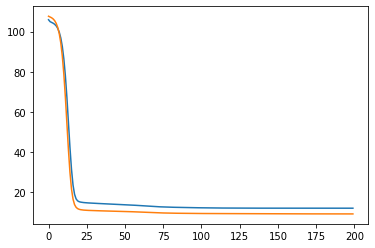

In [40]:
plt.plot(range(len(train_loss)), train_loss);
plt.plot(range(len(val_loss)), val_loss);

# Testing

We have kept the calculation of the test error separate in order to emphasize that you should not use the test set in optimization.

In [41]:
output_test = forward(x_test, NN)

Test loss:  9.841


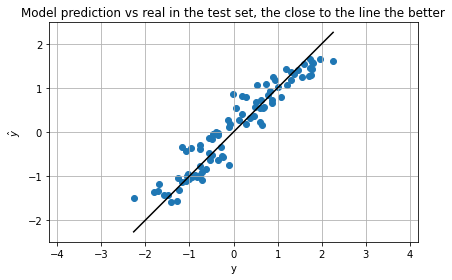

In [42]:
y_test_np = Var_to_nparray(y_test)
plt.scatter(y_test_np, Var_to_nparray(output_test));
plt.plot([np.min(y_test_np), np.max(y_test_np)], [np.min(y_test_np), np.max(y_test_np)], color='k');
plt.xlabel("y");
plt.ylabel("$\hat{y}$");
plt.title("Model prediction vs real in the test set, the close to the line the better")
plt.grid(True);
plt.axis('equal');
plt.tight_layout();

Loss_test = squared_loss(y_test, forward(x_test, NN))

print("Test loss:  {:4.3f}".format(Loss_test.v))

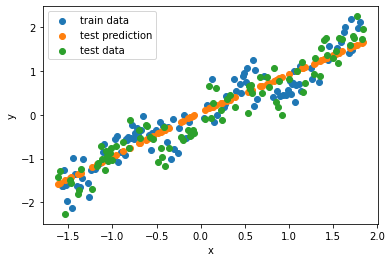

In [43]:
x_test_np = Var_to_nparray(x_test)
x_train_np = Var_to_nparray(x_train)
y_train_np = Var_to_nparray(y_train)
if D1:
    plt.scatter(x_train_np, y_train_np, label="train data");
    plt.scatter(x_test_np, Var_to_nparray(output_test), label="test prediction");
    plt.scatter(x_test_np, y_test_np, label="test data");
    plt.legend();
    plt.xlabel("x");
    plt.ylabel("y");
else:
    plt.scatter(x_train_np[:,1], y_train, label="train data");
    plt.scatter(x_test_np[:,1], Var_to_nparray(output_test), label="test data prediction");
    plt.scatter(x_test_np[:,1], y_test_np, label="test data");
    plt.legend();
    plt.xlabel("x");
    plt.ylabel("y");

## Exercise k) Show overfitting, underfitting and just right fitting

Vary the architecture and other things to show clear signs of overfitting (=training loss significantly lower than test loss) and underfitting (=not fitting enoung to training data so that test performance is also hurt).

See also if you can get a good compromise which leads to a low validation loss. 

For this problem do you see any big difference between validation and test loss? The answer here will probably be no. Discuss cases where it is important to keep the two separate.



### Underfitting

   0 ( 0.00%) Train loss: 107.316 	 Validation loss: 104.882
  10 ( 5.00%) Train loss: 12.039 	 Validation loss: 8.994
  20 (10.00%) Train loss: 12.031 	 Validation loss: 8.979
  30 (15.00%) Train loss: 12.031 	 Validation loss: 8.979
  40 (20.00%) Train loss: 12.031 	 Validation loss: 8.979
  50 (25.00%) Train loss: 12.031 	 Validation loss: 8.979
  60 (30.00%) Train loss: 12.031 	 Validation loss: 8.979
  70 (35.00%) Train loss: 12.031 	 Validation loss: 8.979
  80 (40.00%) Train loss: 12.031 	 Validation loss: 8.979
  90 (45.00%) Train loss: 12.031 	 Validation loss: 8.979
 100 (50.00%) Train loss: 12.031 	 Validation loss: 8.979
 110 (55.00%) Train loss: 12.031 	 Validation loss: 8.979
 120 (60.00%) Train loss: 12.031 	 Validation loss: 8.979
 130 (65.00%) Train loss: 12.031 	 Validation loss: 8.979
 140 (70.00%) Train loss: 12.031 	 Validation loss: 8.979
 150 (75.00%) Train loss: 12.031 	 Validation loss: 8.979
 160 (80.00%) Train loss: 12.031 	 Validation loss: 8.979
 170 (85.00

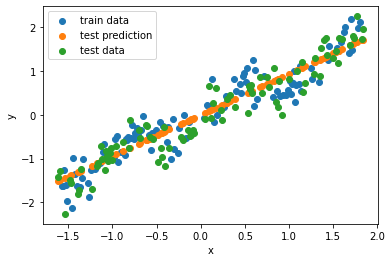

In [51]:
NN = [
    DenseLayer(1, 4, lambda x: x.identity()),
    DenseLayer(4, 1, lambda x: x.identity())
]

train_loss = []
val_loss = []

for e in range(EPOCHS):
     
    # Forward pass and loss computation
    Loss = squared_loss(y_train, forward(x_train, NN))
    #Loss = cross_entropy_loss(y_train, forward(x_train, NN))
    
    # Backward pass
    Loss.backward()
    
    # gradient descent update
    update_parameters(parameters(NN), LEARN_R)
    zero_gradients(parameters(NN))
    
    # Training loss
    train_loss.append(Loss.v)
    
    # Validation
    Loss_validation = squared_loss(y_validation, forward(x_validation, NN))
    val_loss.append(Loss_validation.v)
    
    if e%10==0:
        print("{:4d}".format(e),
              "({:5.2f}%)".format(e/EPOCHS*100), 
              "Train loss: {:4.3f} \t Validation loss: {:4.3f}".format(train_loss[-1], val_loss[-1]))
        
output_test = forward(x_test, NN)
y_test_np = Var_to_nparray(y_test)
Loss_test = squared_loss(y_test, forward(x_test, NN))

x_test_np = Var_to_nparray(x_test)
x_train_np = Var_to_nparray(x_train)
y_train_np = Var_to_nparray(y_train)
if D1:
    plt.scatter(x_train_np, y_train_np, label="train data");
    plt.scatter(x_test_np, Var_to_nparray(output_test), label="test prediction");
    plt.scatter(x_test_np, y_test_np, label="test data");
    plt.legend();
    plt.xlabel("x");
    plt.ylabel("y");
else:
    plt.scatter(x_train_np[:,1], y_train, label="train data");
    plt.scatter(x_test_np[:,1], Var_to_nparray(output_test), label="test data prediction");
    plt.scatter(x_test_np[:,1], y_test_np, label="test data");
    plt.legend();
    plt.xlabel("x");
    plt.ylabel("y");


### Overfitting

   0 ( 0.00%) Train loss: 104.945 	 Validation loss: 107.678
  10 ( 1.25%) Train loss: 104.869 	 Validation loss: 107.614
  20 ( 2.50%) Train loss: 104.800 	 Validation loss: 107.538
  30 ( 3.75%) Train loss: 104.689 	 Validation loss: 107.414
  40 ( 5.00%) Train loss: 104.484 	 Validation loss: 107.179
  50 ( 6.25%) Train loss: 104.028 	 Validation loss: 106.646
  60 ( 7.50%) Train loss: 102.621 	 Validation loss: 104.884
  70 ( 8.75%) Train loss: 94.159 	 Validation loss: 93.041
  80 (10.00%) Train loss: 32.732 	 Validation loss: 36.618
  90 (11.25%) Train loss: 25.672 	 Validation loss: 33.908
 100 (12.50%) Train loss: 28.157 	 Validation loss: 41.609
 110 (13.75%) Train loss: 25.379 	 Validation loss: 37.209
 120 (15.00%) Train loss: 24.889 	 Validation loss: 35.076
 130 (16.25%) Train loss: 23.556 	 Validation loss: 31.074
 140 (17.50%) Train loss: 23.007 	 Validation loss: 29.122
 150 (18.75%) Train loss: 22.579 	 Validation loss: 26.741
 160 (20.00%) Train loss: 21.455 	 Validat

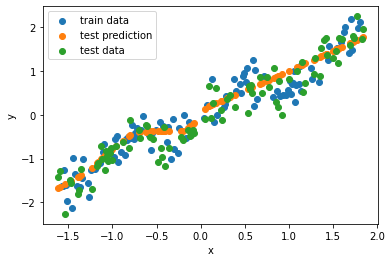

In [57]:
NN = [
    DenseLayer(1, 12, lambda x: x.relu()),
    DenseLayer(12, 8, lambda x: x.relu()),
    DenseLayer(8, 8, lambda x: x.relu()),
    DenseLayer(8, 8, lambda x: x.relu()),
    DenseLayer(8, 1, lambda x: x.identity())
]

train_loss = []
val_loss = []

EPOCHS = 800

for e in range(EPOCHS):
     
    # Forward pass and loss computation
    Loss = squared_loss(y_train, forward(x_train, NN))
    #Loss = cross_entropy_loss(y_train, forward(x_train, NN))
    
    # Backward pass
    Loss.backward()
    
    # gradient descent update
    update_parameters(parameters(NN), LEARN_R)
    zero_gradients(parameters(NN))
    
    # Training loss
    train_loss.append(Loss.v)
    
    # Validation
    Loss_validation = squared_loss(y_validation, forward(x_validation, NN))
    val_loss.append(Loss_validation.v)
    
    if e%10==0:
        print("{:4d}".format(e),
              "({:5.2f}%)".format(e/EPOCHS*100), 
              "Train loss: {:4.3f} \t Validation loss: {:4.3f}".format(train_loss[-1], val_loss[-1]))
        
output_test = forward(x_test, NN)
y_test_np = Var_to_nparray(y_test)
Loss_test = squared_loss(y_test, forward(x_test, NN))

x_test_np = Var_to_nparray(x_test)
x_train_np = Var_to_nparray(x_train)
y_train_np = Var_to_nparray(y_train)
if D1:
    plt.scatter(x_train_np, y_train_np, label="train data");
    plt.scatter(x_test_np, Var_to_nparray(output_test), label="test prediction");
    plt.scatter(x_test_np, y_test_np, label="test data");
    plt.legend();
    plt.xlabel("x");
    plt.ylabel("y");
else:
    plt.scatter(x_train_np[:,1], y_train, label="train data");
    plt.scatter(x_test_np[:,1], Var_to_nparray(output_test), label="test data prediction");
    plt.scatter(x_test_np[:,1], y_test_np, label="test data");
    plt.legend();
    plt.xlabel("x");
    plt.ylabel("y");

### Just right

   0 ( 0.00%) Train loss: 104.922 	 Validation loss: 107.744
  10 ( 2.50%) Train loss: 104.494 	 Validation loss: 107.202
  20 ( 5.00%) Train loss: 103.336 	 Validation loss: 105.879
  30 ( 7.50%) Train loss: 97.368 	 Validation loss: 98.701
  40 (10.00%) Train loss: 46.709 	 Validation loss: 38.203
  50 (12.50%) Train loss: 51.024 	 Validation loss: 42.497
  60 (15.00%) Train loss: 18.677 	 Validation loss: 15.070
  70 (17.50%) Train loss: 17.728 	 Validation loss: 14.158
  80 (20.00%) Train loss: 16.647 	 Validation loss: 13.096
  90 (22.50%) Train loss: 15.480 	 Validation loss: 11.902
 100 (25.00%) Train loss: 14.313 	 Validation loss: 10.773
 110 (27.50%) Train loss: 13.235 	 Validation loss: 9.801
 120 (30.00%) Train loss: 12.571 	 Validation loss: 9.264
 130 (32.50%) Train loss: 12.195 	 Validation loss: 9.001
 140 (35.00%) Train loss: 12.012 	 Validation loss: 8.872
 150 (37.50%) Train loss: 11.937 	 Validation loss: 8.828
 160 (40.00%) Train loss: 11.880 	 Validation loss: 8.7

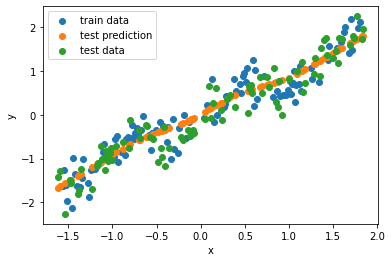

In [56]:
NN = [
    DenseLayer(1, 8, lambda x: x.relu()),
    DenseLayer(8, 8, lambda x: x.relu()),
    DenseLayer(8, 8, lambda x: x.relu()),
    DenseLayer(8, 1, lambda x: x.identity())
]

train_loss = []
val_loss = []

EPOCHS = 400

for e in range(EPOCHS):
     
    # Forward pass and loss computation
    Loss = squared_loss(y_train, forward(x_train, NN))
    #Loss = cross_entropy_loss(y_train, forward(x_train, NN))
    
    # Backward pass
    Loss.backward()
    
    # gradient descent update
    update_parameters(parameters(NN), LEARN_R)
    zero_gradients(parameters(NN))
    
    # Training loss
    train_loss.append(Loss.v)
    
    # Validation
    Loss_validation = squared_loss(y_validation, forward(x_validation, NN))
    val_loss.append(Loss_validation.v)
    
    if e%10==0:
        print("{:4d}".format(e),
              "({:5.2f}%)".format(e/EPOCHS*100), 
              "Train loss: {:4.3f} \t Validation loss: {:4.3f}".format(train_loss[-1], val_loss[-1]))
        
output_test = forward(x_test, NN)
y_test_np = Var_to_nparray(y_test)
Loss_test = squared_loss(y_test, forward(x_test, NN))

x_test_np = Var_to_nparray(x_test)
x_train_np = Var_to_nparray(x_train)
y_train_np = Var_to_nparray(y_train)
if D1:
    plt.scatter(x_train_np, y_train_np, label="train data");
    plt.scatter(x_test_np, Var_to_nparray(output_test), label="test prediction");
    plt.scatter(x_test_np, y_test_np, label="test data");
    plt.legend();
    plt.xlabel("x");
    plt.ylabel("y");
else:
    plt.scatter(x_train_np[:,1], y_train, label="train data");
    plt.scatter(x_test_np[:,1], Var_to_nparray(output_test), label="test data prediction");
    plt.scatter(x_test_np[:,1], y_test_np, label="test data");
    plt.legend();
    plt.xlabel("x");
    plt.ylabel("y");

### Conclusion
In the first fit, we choose to use the identity kernel as activation functions, this meant that the NN in fact collapses into a linear model. In other words, the first NN corresponds to fitting a affine function to the data, which is evident from the plots. This is an example of a clear underfit. 


In the second fit, the size of the NN has been greatly increased. This meant that it took longer for the gradient descent to converge, hence it was neccesary to increase the number of iterations. 

In the final fit, both the train loss and the validation loss decreases quite rapidly together indicating at good balance.

NB:
The "overfit" example here is actually not a overfit. We would really have wanted to use more layers with more neurons in each, however, due to computational limitations we did not. Increasing the size of the NN we would expect to reach some point, were the train loss continues to decrease but the validation loss suddenly increases, indicating that we are overfitting the test data. 


# Next steps - classification

It is straight forward to extend what we have done to classification. 

For numerical stability it is better to make softmax and cross-entropy as one function so we write the cross entropy loss as a function of the logits we talked about last week. 

Next week we will see how to perform classification in PyTorch.

## Exercise l) optional - Implement backpropagation for classification

Should be possible with very few lines of code. :-)

In [35]:
# Just add code.

## Exercise m) optional - Introduce a NeuralNetwork class

The functions we applied on the neural network (parameters, update_parameters and zero_gradients) can more naturally be included as methods in a NeuralNetwork class. Make such a class and modify the code to use it. 

In [36]:
# just add some code